# Modeling callable bonds

In this chapter, lets take a look at  valuing callable bonds in QuantLib Python. The approach to construct a callable bond is lot similar to [modeling a fixed rate bond in QuantLib](#fixedratebonds). The one additional input that we need to provide here is the details on the call or put schedule. If you follow the fixed rate bond example already, this should be fairly straight forward.

As always, we will start with some initializations and imports.

In [1]:
import QuantLib as ql
import numpy as np
import utils
%matplotlib inline
calc_date = ql.Date(16,8,2016)
ql.Settings.instance().evaluationDate = calc_date

# This is for compatibility with QuantLib < 1.22
try:
    ql.BondPrice
except:
    ql.BondPrice = ql.CallabilityPrice

For simplicity, let us assume that the interest rate term structure is a flat yield curve at 3.5%. You can refer to [constructing yield curves](#yc-construction) for more details on constructing yield curves.

In [2]:
day_count = ql.ActualActual(ql.ActualActual.Bond)
rate = 0.035
ts = ql.FlatForward(calc_date, rate, 
                    day_count, ql.Compounded, 
                    ql.Semiannual)
ts_handle = ql.YieldTermStructureHandle(ts)

The call and put schedules for the callable bond is created as shown below. We create a container for holding all the call and put dates using the `CallabilitySchedule` class. You can add each call using `Callability` class and noting as `Callability.Call` or `Callability.Put` for either a call or put.

In [3]:
callability_schedule = ql.CallabilitySchedule()
call_price = 100.0
call_date = ql.Date(15,ql.September,2016);
null_calendar = ql.NullCalendar();
for i in range(0,24):
    callability_price  = ql.BondPrice(
        call_price, ql.BondPrice.Clean)
    callability_schedule.append(
            ql.Callability(callability_price, 
                           ql.Callability.Call,
                           call_date))

    call_date = null_calendar.advance(call_date, 3, 
                                      ql.Months)

What follows next is similar to the `Schedule` that we created in the vanilla fixed rate bond valuation.

In [4]:
issue_date = ql.Date(16,ql.September,2014)        
maturity_date = ql.Date(15,ql.September,2022)
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
tenor = ql.Period(ql.Quarterly)
accrual_convention = ql.Unadjusted

schedule = ql.Schedule(issue_date, maturity_date, tenor,
                       calendar, accrual_convention, 
                       accrual_convention,
                       ql.DateGeneration.Backward, False)

The callable bond is instantiated using the `CallableFixedRateBond` class, which accepts the bond inputs and the call or put schedule.

In [5]:
settlement_days = 3
face_amount = 100
accrual_daycount = ql.ActualActual(ql.ActualActual.Bond)
coupon = 0.025


bond = ql.CallableFixedRateBond(
    settlement_days, face_amount,
    schedule, [coupon], accrual_daycount,
    ql.Following, face_amount, issue_date,
    callability_schedule)

In order to value the bond, we need an interest rate model to model the fact that the bond will get called or not in the future depending on where the future interest rates are at. The `TreeCallableFixedRateBondEngine` can be used to value the callable bond. Below, the `value_bond` function prices the callable bond based on the Hull-White model parameter for mean reversion and volatility.

In [6]:
def value_bond(a, s, grid_points, bond):
    model = ql.HullWhite(ts_handle, a, s)
    engine = ql.TreeCallableFixedRateBondEngine(model, grid_points)
    bond.setPricingEngine(engine)
    return bond

The callable bond value for a 3% mean reversion and 12% volatility is shown below.

In [7]:
value_bond(0.03, 0.12, 40, bond)
print("Bond price: %lf" % bond.cleanPrice())

Bond price: 68.396593


The price sensitivity of callable bonds to that of volatility parameter is shown below. As volatility increases, there is a higher chance of it being callable. Hence the value of the bond decreases.

In [8]:
sigmas = np.arange(0.001, 0.15, 0.001)
prices = [value_bond(0.03, s, 40, bond).cleanPrice() 
          for s in sigmas]

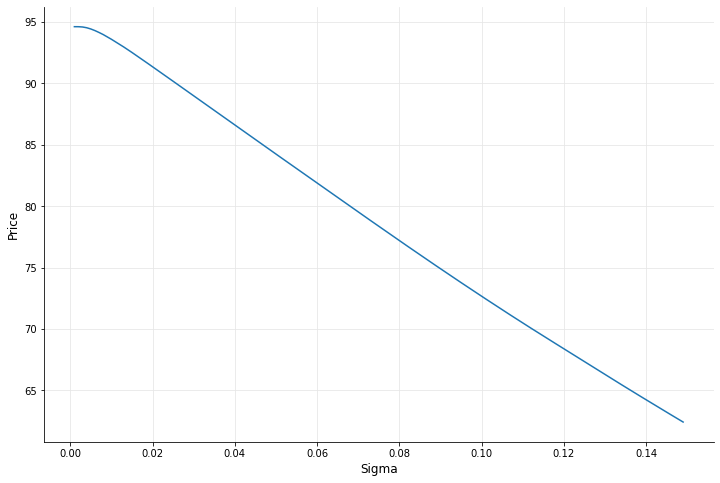

In [9]:
_, ax = utils.plot()
ax.plot(sigmas, prices)
ax.set_xlabel("Sigma", size=12)
ax.set_ylabel("Price", size=12);

The static cash flows can be accessed using the `cashflows` accessor.

In [10]:
from pandas import DataFrame
DataFrame(
    [(cf.date(), cf.amount()) for cf in bond.cashflows()],
    columns=["Date", "Amount"],
    index=range(1, len(bond.cashflows())+1))

,Date,Amount
1,"December 15th, 2014",0.618132
2,"March 16th, 2015",0.625000
3,"June 15th, 2015",0.625000
4,"September 15th, 2015",0.625000
5,"December 15th, 2015",0.625000
6,"March 15th, 2016",0.625000
7,"June 15th, 2016",0.625000
8,"September 15th, 2016",0.625000
9,"December 15th, 2016",0.625000
10,"March 15th, 2017",0.625000


#### Conclusion

Here we explored a minimal example on pricing a callable bond.